In [1]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
import os

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: /device:GPU:0


In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip


--2022-02-13 19:06:40--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.85.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.85.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  62.4MB/s    in 12s     

2022-02-13 19:06:52 (67.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2022-02-13 19:06:52--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.130.105
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.130.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.6MB/s    in 2.5s    

2022-02-

In [3]:
%%capture
!unzip val2017.zip

!unzip stuff_annotations_trainval2017.zip

!unzip annotations_trainval2017.zip

In [4]:
#function to display any image
def display_image(image):
  fig = plt.figure(figsize=(10, 15))
  plt.grid(False)
  plt.imshow(image)


In [5]:
#Draw the bounding boxes on image
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


In [16]:
#Draw labels and bounding boxes on image
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  count = 0
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              14)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      count = count + 1
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      width = xmax - xmin
      height = ymax - ymin
      width_ft = (width * 13000) /1152
      height_ft = (height * 13000) /1152
      print("Object name: ", class_names[i].decode("ascii"))
      print("width of " + class_names[i].decode("ascii") + " in pixels: ", width)
      print("height of " + class_names[i].decode("ascii") + " in pixels: ", height)
      print("width of " + class_names[i].decode("ascii") + " in feets: ", width_ft)
      print("height of " + class_names[i].decode("ascii") + " in feets: ", height_ft)
      
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image, count

In [7]:
#run the detection on the image
def run_detector(detector, path,filename):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print("Inference time: ", end_time-start_time)

  image_with_boxes, count = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
  print("Found %d objects." % count)
  save_image(image_with_boxes,filename)

In [8]:
#Resize the image to a lower resolution than 300x300 pixels and save it in tmp folder
def download_and_resize_image(img, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  pil_image = Image.open(img)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


In [9]:
#Save the detected image with bounding boxes in the specified folder 
def save_image(img,filename):
  PATH = "/content/Detected_images"
  PIL_img = Image.fromarray(np.uint8(img)).convert("RGB")
  target_path = os.path.join(PATH,filename)
  PIL_img.save(target_path, format = "JPEG", quality = 90)


In [10]:
#Convert image to tensor
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  print(img)
  return img

In [11]:
#Loading the object detector
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Image downloaded to /tmp/tmp4yyhek30.jpg.
tf.Tensor(
[[[192 185 179]
  [192 185 179]
  [189 185 176]
  ...
  [188 183 177]
  [187 184 179]
  [187 184 179]]

 [[190 183 177]
  [191 184 178]
  [189 185 176]
  ...
  [188 183 177]
  [187 184 179]
  [187 184 179]]

 [[189 182 176]
  [190 183 177]
  [189 185 176]
  ...
  [188 183 177]
  [187 184 179]
  [187 184 179]]

 ...

 [[185 180 174]
  [185 180 174]
  [187 180 172]
  ...
  [189 182 174]
  [188 181 173]
  [188 181 173]]

 [[185 180 174]
  [184 179 173]
  [187 180 172]
  ...
  [189 182 174]
  [187 183 174]
  [187 183 174]]

 [[184 179 173]
  [184 179 173]
  [187 180 172]
  ...
  [190 183 175]
  [187 183 174]
  [187 183 174]]], shape=(256, 300, 3), dtype=uint8)
Inference time:  1.5584139823913574
Object name:  Person
width of Person in pixels:  0.2961332
height of Person in pixels:  0.49187678
width of Person in feets:  3.3417807943705053
height of Person in feets:  5.550692840996716
Object name:  Footwear
width of Footwear in pixels:  0.

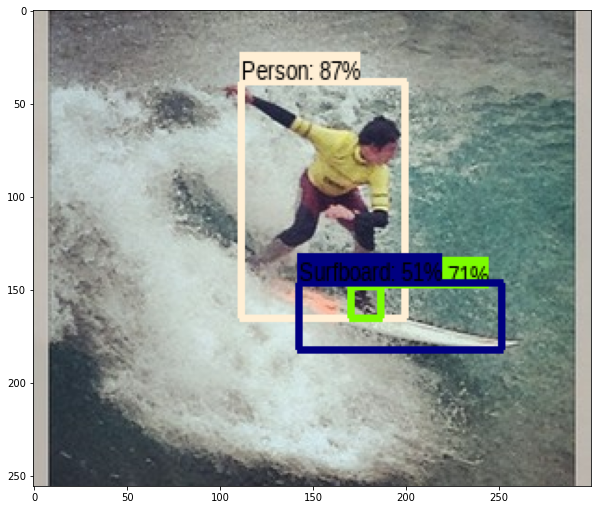

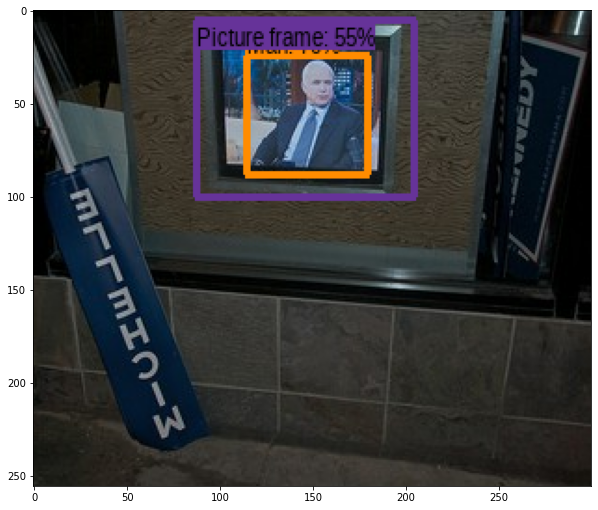

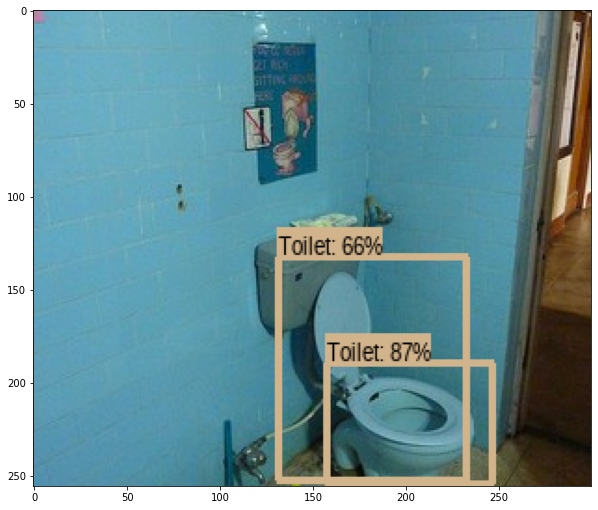

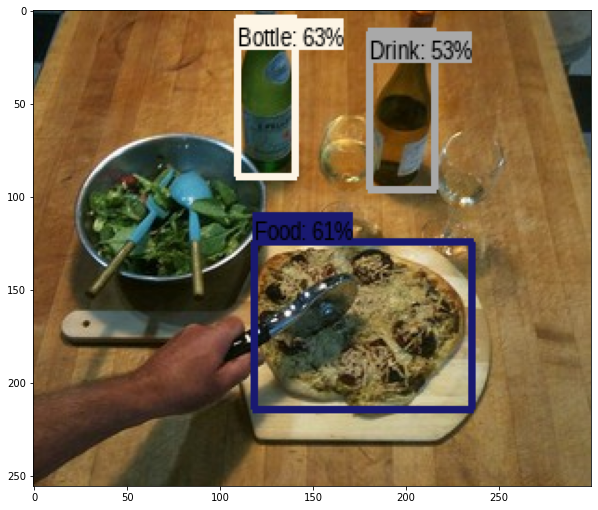

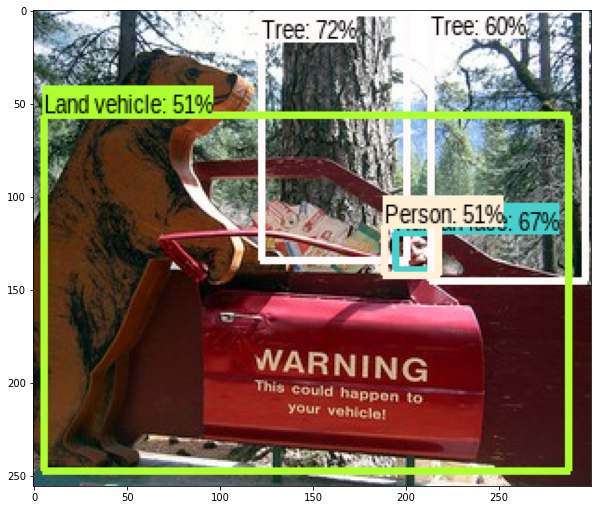

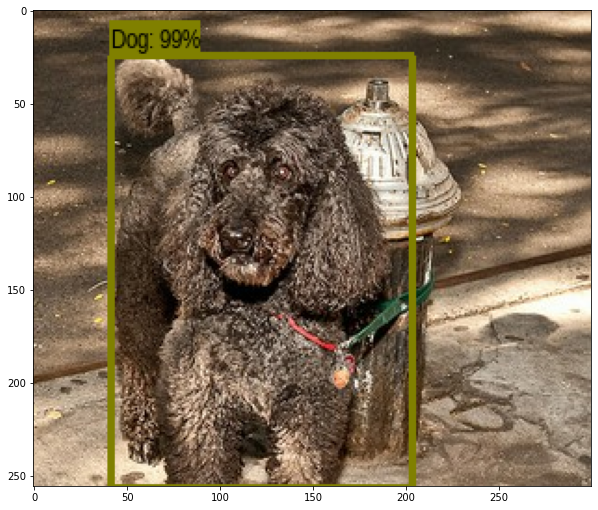

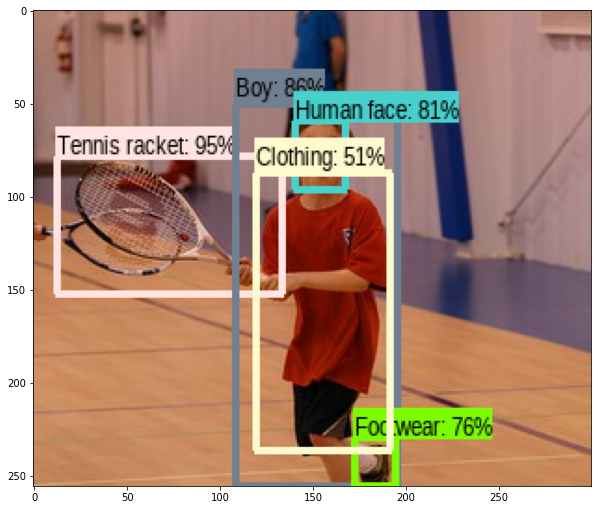

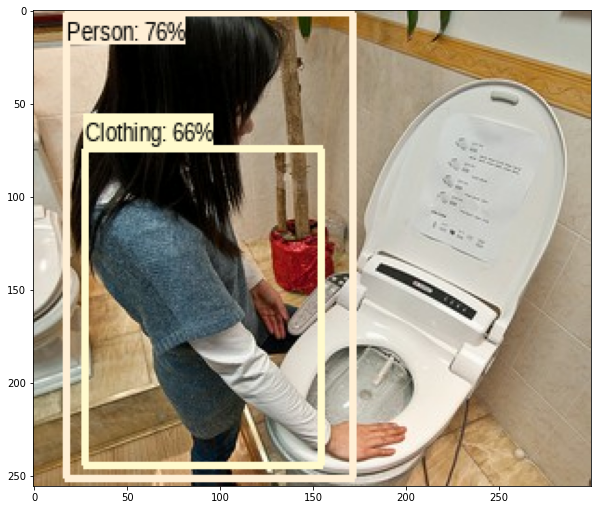

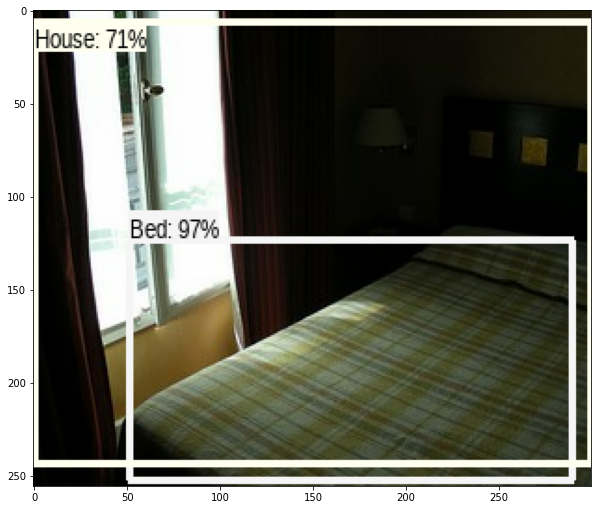

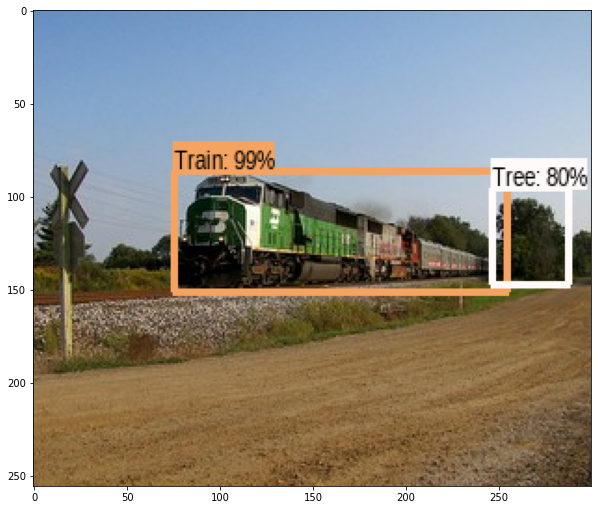

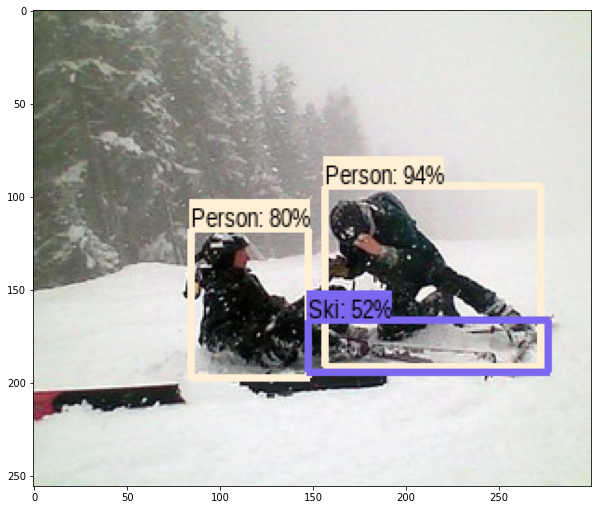

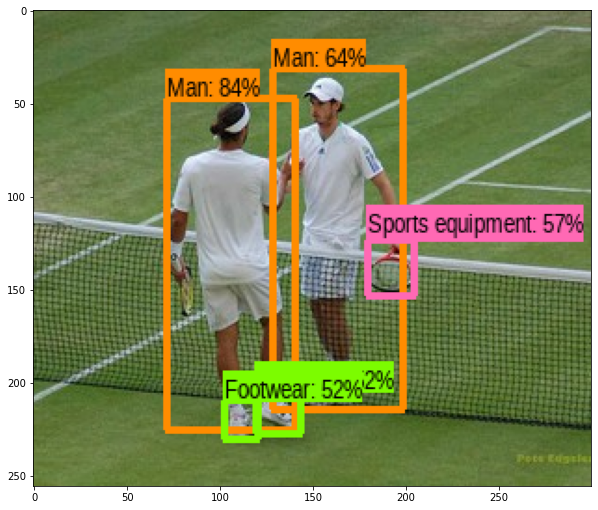

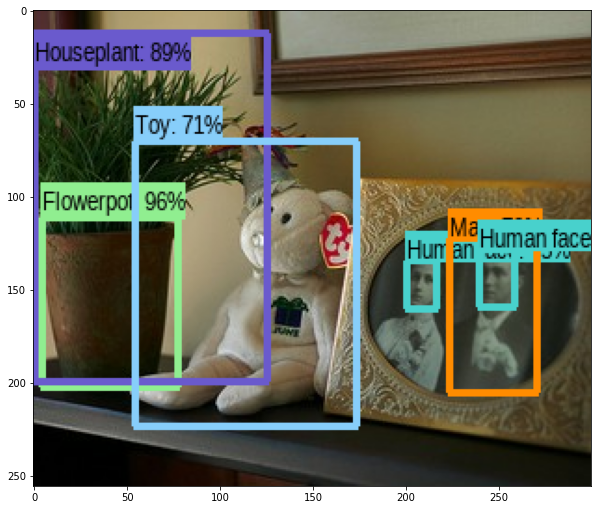

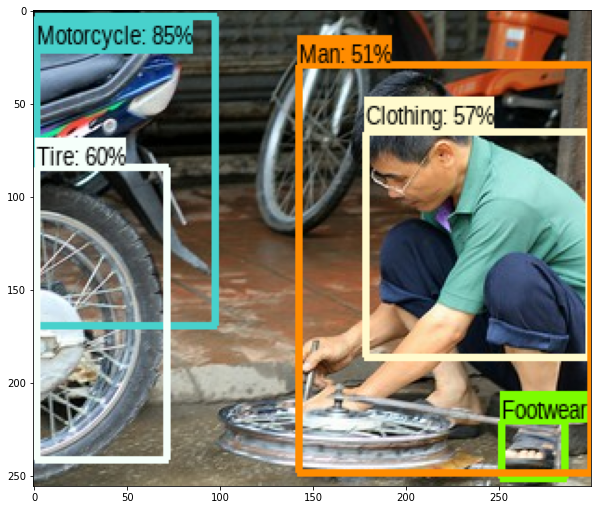

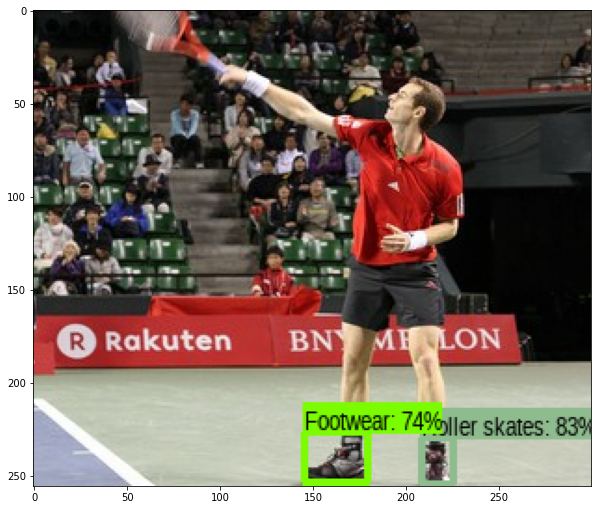

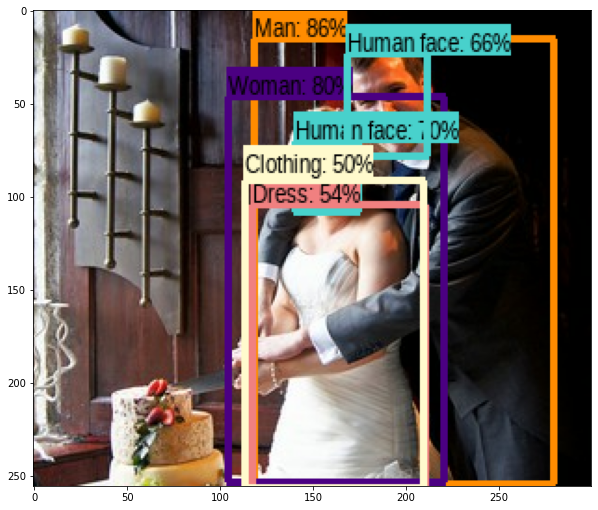

In [17]:
#Running detection on all images one by one
path_images = "/content/val2017"
for filename in os.listdir(path_images):
  actual_img = os.path.join(path_images,filename)
  base_name = os.path.basename(actual_img)
  downloaded_image_path = download_and_resize_image(actual_img, 300, 256, False)
  run_detector(detector, downloaded_image_path,base_name)
  
